In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
sys.path.insert(1, '../src/siamese_triplet')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from networks import EmbeddingNet
from losses import OnlineTripletLoss, ContrastiveLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric
torch.manual_seed(0)
from train import simplified_fit
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
is_cuda = torch.cuda.is_available()

In [3]:
data_dir = '../data/processed/'
data_name = 'top10.json'
#data_name = 'top_10_authors.json'
prefix = data_name[:-5]

file_embedding = prefix + '_embedding.pkl'
file_dict = prefix + '_dict.pkl'
tokenized_train_data = prefix + '_train.pkl'
tokenized_valid_data = prefix + '_valid.pkl'
tokenized_test_data = prefix + '_test.pkl'

In [4]:
with open(data_dir+file_dict, 'rb') as f:
    token2index_dict = pickle.load(f)

with open(data_dir+file_embedding, 'rb') as f:
    emb = torch.tensor(pickle.load(f))

### New way tokenizing and batching

In [5]:
from datasets import BalancedBatchSampler, data_to_Iterator, _data_to_Iterator
#test_Loader = data_to_Iterator(data_dir,tokenized_test_data, n_classes=10, n_samples=10, sampler= True)
#valid_Loader = data_to_Iterator(data_dir,tokenized_valid_data, n_classes=10, n_samples=10, sampler= True)
#train_Loader = data_to_Iterator(data_dir,tokenized_train_data, n_classes=10, n_samples=10, sampler= True)

In [6]:
from datasets import Siamese_Iterator
test_Loader = Siamese_Iterator(data_dir, tokenized_test_data, batch_size = 64, state = 'test')
valid_Loader = Siamese_Iterator(data_dir, tokenized_valid_data, batch_size = 128, state = 'test')
train_Loader = Siamese_Iterator(data_dir, tokenized_train_data, batch_size = 128, state = 'train')

In [7]:
from datasets import Siamese_Test_Iterator
test_Loader_ = Siamese_Test_Iterator(data_dir, tokenized_test_data)
valid_Loader_ = Siamese_Test_Iterator(data_dir, tokenized_valid_data)
train_Loader_ = Siamese_Test_Iterator(data_dir, tokenized_train_data)

In [8]:
train_Loader_

for i in train_Loader:
    aux = i
    break
print(aux[0].shape)

for i in train_Loader:
    aux = i
    break
print(type(aux[0]))
print(type(aux[1]))
print(aux[1].shape)
print(aux[0][1].shape)

In [9]:
test_Loader

In [10]:
for i in train_Loader:
    aux = i
    break
print(type(aux[0]))
print(type(aux[1]))
print(aux[1].shape)
print(aux[0][1].shape)

<class 'list'>
<class 'torch.Tensor'>
torch.Size([128])
torch.Size([128, 101])


## Plotting function

In [41]:
mnist_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

author_list =  ['alfred_lord_tennyson', 'algernon_charles_swinburne', 'robert_browning', 'alexander_pope', 'walt_whitman', 'william_wordsworth', 'william_shakespeare', 
                'edmund_spenser', 'matthew_arnold', 'percy_shelley', 'beowulf', 'john_dryden'] 

author_dict = {i: j  for i,j in enumerate(author_list)}


mnist_classes = [author_dict[i] for i in mnist_classes]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#17becf', '#17becf']

#"#000000" "#800000"
    


def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)

## Build the Model



In [42]:
sys.path.insert(1, '../src/')
from models import CNN, SiameseNet

In [64]:

AUTHOR_DIM = 2
PAD_IDX = 1
UNK_IDX = 0
INPUT_DIM = emb.size(0)
WORD_EMBEDDING_DIM = 100
FILTER_SIZES = [2,3,4]
DROPOUT = 0.50
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
N_LAYERS = 1
BIDIRECTIONAL = True

#model = RNN(INPUT_DIM, 
#            EMBEDDING_DIM, 
#            HIDDEN_DIM, 
#            AUTHOR_DIM, 
#            N_LAYERS, 
#            BIDIRECTIONAL, 
#            DROPOUT, 
#            PAD_IDX)

WORD_EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
model = CNN(INPUT_DIM, WORD_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, AUTHOR_DIM, DROPOUT, PAD_IDX)
pretrained_embeddings = emb 
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(WORD_EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(WORD_EMBEDDING_DIM)

embedding_net = model
MODEL = SiameseNet(embedding_net)

In [68]:
# Set up the network and training parameters
import train_siamese

MARGIN = 0.5
embedding_net = EmbeddingNet()
MODEL= MODEL.to(device)
loss_fn = ContrastiveLoss(MARGIN)
LR = 4e-3 
optimizer = optim.Adam(model.parameters(), lr=LR)
n_epochs = 15
log_interval = 4
train_siamese.simplified_fit(train_Loader, valid_Loader, MODEL, loss_fn, optimizer, 
    n_epochs, is_cuda, metrics=[])

Train: [0/1563 (0%)]	Loss: 0.049798
Train: [606/1563 (46%)]	Loss: 0.040240
Train: [1212/1563 (92%)]	Loss: 0.050424
Epoch: 1/15. Train set: Average loss: 0.0457
Epoch: 1/15. Validation set: Avg loss: 0.0488
Train: [0/1563 (0%)]	Loss: 0.034498
Train: [606/1563 (46%)]	Loss: 0.041349
Train: [1212/1563 (92%)]	Loss: 0.042491
Epoch: 2/15. Train set: Average loss: 0.0413
Epoch: 2/15. Validation set: Avg loss: 0.0419
Train: [0/1563 (0%)]	Loss: 0.044869
Train: [606/1563 (46%)]	Loss: 0.044306
Train: [1212/1563 (92%)]	Loss: 0.043622
Epoch: 3/15. Train set: Average loss: 0.0440
Epoch: 3/15. Validation set: Avg loss: 0.0476
Train: [0/1563 (0%)]	Loss: 0.043952
Train: [606/1563 (46%)]	Loss: 0.042768
Train: [1212/1563 (92%)]	Loss: 0.041074
Epoch: 4/15. Train set: Average loss: 0.0421
Epoch: 4/15. Validation set: Avg loss: 0.0411
Train: [0/1563 (0%)]	Loss: 0.041638
Train: [606/1563 (46%)]	Loss: 0.040956
Train: [1212/1563 (92%)]	Loss: 0.040766
Epoch: 5/15. Train set: Average loss: 0.0409
Epoch: 5/15. Val

([], [])

# Plotting time

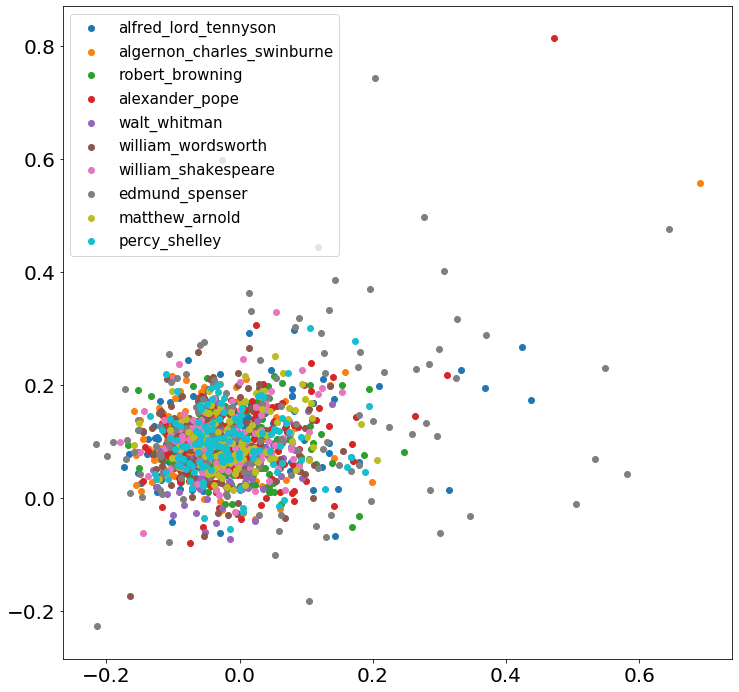

In [69]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#17cf84', '#1e2161']


def extract_embeddings(dataloader, model, emb_dim):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.unsqueeze(0)
            poems_le= len(poems)
            if is_cuda:
                poems = poems.cuda()

            embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels


def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(12,12))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=1,linewidths=1 , color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes, prop={'size': 15} )
    plt.tick_params(axis='both', labelsize=20)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)
        
train_embeddings_otl, train_labels_otl = extract_embeddings(train_Loader_, model, AUTHOR_DIM)
plot_embeddings(train_embeddings_otl, train_labels_otl, save_plot='training.png')

In [77]:
def extract_embeddings(dataloader, model, emb_dim):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.unsqueeze(0)
            poems_le= len(poems)
            if is_cuda:
                poems = poems.cuda()

            embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels

valid_embeddings_otl, valid_labels_otl = extract_embeddings(valid_Loader, model, AUTHOR_DIM)
plot_embeddings(valid_embeddings_otl, valid_labels_otl,save_plot='valid.png')

AttributeError: 'list' object has no attribute 'unsqueeze'

In [78]:
test_embeddings_otl, test_labels_otl = extract_embeddings(test_Loader, model, AUTHOR_DIM)
plot_embeddings(test_embeddings_otl, test_labels_otl,save_plot='valid.png')

AttributeError: 'list' object has no attribute 'unsqueeze'

In [79]:
from sklearn.neighbors import KNeighborsClassifier as KNC
for i in range(1,5):
    KNN = KNC(n_neighbors=i)
    KNN.fit(train_embeddings_otl, train_labels_otl)
    print(KNN.score(valid_embeddings_otl,valid_labels_otl))

0.10919540229885058
0.21839080459770116
0.21839080459770116
0.2413793103448276


In [80]:
#test_embeddings_otl, test_labels_otl = extract_embeddings(test_Loader, MODEL, AUTHOR_DIM)
KNN.score(test_embeddings_otl,test_labels_otl)

0.2574626865671642

import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

_data, _labels = (train_embeddings_otl, train_labels_otl)

standardized_data = StandardScaler().fit_transform(_data)
print(standardized_data.shape)
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)


tsne_data = np.vstack((tsne_data.T, _labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [23]:
len(test_labels_otl), len(train_labels_otl), len(valid_labels_otl)

(268, 1563, 174)